In [68]:
%matplotlib inline
import numpy as np
import time
import copy
import os
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torchvision.transforms as transforms
from datetime import datetime 
import torch.nn.functional as F


In [86]:
data_dir = 'content'

data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((32,32)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees = 7, 
                               translate = (0, 0.07), # horizontal and vertical shifts
                               shear = 7,
                               scale = (1, 1.2) # zoom range
                               ),
        transforms.ToTensor(),

    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((32,32)),
        transforms.ToTensor(),
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, #better updates on grad
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [87]:

def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for inputs, labels in data_loader:

            inputs = inputs.to(device)
            labels = labels.to(device)

            _, output_prob = model(inputs) # remember output_prob is probabilities with softMax already
            _, predicted_labels = torch.max(output_prob, 1)

            n += labels.size(0)
            correct_pred += (predicted_labels == labels).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    #fig.show()
    
    # change the plot style to default
    plt.style.use('default')
    
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for inputs, labels in train_loader:

        optimizer.zero_grad()
        
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        # Forward pass
        outputs, _ = model(inputs) 
        loss = criterion(outputs, labels) 
        running_loss += loss.item() * inputs.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
    model.eval()
    running_loss = 0
    
    for inputs, labels in valid_loader:
    
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass and record loss
        outputs, _ = model(inputs) 
        loss = criterion(outputs, labels) 
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    best_acc = 0.0
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    # Train model and validate
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
            
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')
            
        if valid_acc > best_acc:
            #update best acc and save a state.dict with that. We'll save the best acc, not the last of training 
            best_acc = valid_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        

    plot_losses(train_losses, valid_losses)
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

In [126]:
class EchidNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=4, stride=1),
            nn.ReLU6(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=10, kernel_size=4, stride=1),
            nn.ReLU6(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=10, out_channels=60, kernel_size=5, stride=1),
            nn.ReLU6()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=60, out_features=40),
            nn.ReLU6(),
            nn.Linear(in_features=40, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

02:04:02 --- Epoch: 0	Train loss: 2.8496	Valid loss: 1.6532	Train accuracy: 45.96	Valid accuracy: 53.90
02:04:04 --- Epoch: 1	Train loss: 1.4309	Valid loss: 0.8032	Train accuracy: 67.06	Valid accuracy: 80.09
02:04:06 --- Epoch: 2	Train loss: 0.9174	Valid loss: 0.5206	Train accuracy: 77.71	Valid accuracy: 86.54
02:04:09 --- Epoch: 3	Train loss: 0.6456	Valid loss: 0.3741	Train accuracy: 84.10	Valid accuracy: 90.86
02:04:11 --- Epoch: 4	Train loss: 0.4719	Valid loss: 0.2582	Train accuracy: 87.46	Valid accuracy: 94.57
02:04:14 --- Epoch: 5	Train loss: 0.3939	Valid loss: 0.1986	Train accuracy: 90.55	Valid accuracy: 95.19
02:04:16 --- Epoch: 6	Train loss: 0.3139	Valid loss: 0.1457	Train accuracy: 93.31	Valid accuracy: 97.31
02:04:19 --- Epoch: 7	Train loss: 0.2523	Valid loss: 0.1224	Train accuracy: 94.59	Valid accuracy: 98.08
02:04:21 --- Epoch: 8	Train loss: 0.2083	Valid loss: 0.1059	Train accuracy: 95.01	Valid accuracy: 97.96
02:04:23 --- Epoch: 9	Train loss: 0.1729	Valid loss: 0.0630	Trai

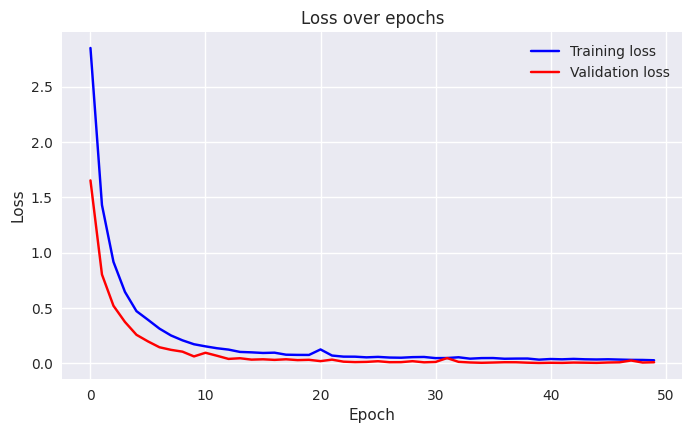

In [129]:
model = EchidNet(n_classes=35)
device = torch.device('cuda')
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model = training_loop(model=model, 
                      criterion=criterion, 
                      optimizer=optimizer, 
                      train_loader=dataloaders["train"], 
                      valid_loader=dataloaders["val"], 
                      epochs=50, 
                      device=device, 
                      print_every=1)

In [130]:
# save the model so you can easily load later
# load with: model.load_state_dict(torch.load(PATH))

PATH = './EchidNet_100-smaller_text_recognizer.pth'
#model.load_state_dict(torch.load(PATH))
torch.save(model.state_dict(), PATH)

In [118]:
def return_model_answer(img_path):
    """
    input: image_path
    output: character on the image classified
    """
    model.eval()
    img = img_path
    np_img = cv2.imread(img_path)
    img_test = Image.open(img)
    img_test = cv2.resize(np_img, (32,32)) # resizing with cv2, that way color channel is kept in the shape (if img has 3 channels (RGB))
    img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY)
    img_test = np.expand_dims(img_test, axis=-1) # RGB images turned into gray with cv2.cvtcolor, which removed the channel (array dimension), so add 1d, because tensor needs that dimension
    img_test = img_test/255
    img_test = img_test.transpose(2,0,1)  #torch data run to neural net with a different order than numpy data, just changing its positions
    img_test = img_test[None,:,:,:]
    img = torch.from_numpy(img_test)
    img= img.cuda() # Disable if not using gpu cuda
    img = img.float()
    # input image to LeNet5 to recognize it
    probs, outputs = model(img) #probs is the tensor with each class output, ouputs are the probs with softmax
    _, predicted = torch.max(outputs,1)
    return format(class_names[predicted])

In [131]:
# we have overall training acc on the model traning method
#this one calculates acc for each character

def class_acc_calculator(n_classes, n_samples):
    count = 0
    samples=0
    num_of_images = 0
    start = time.time()
    for i in range(n_classes):
        for j in range(n_samples):
            try:
                path = f"content/val/{class_names[i]}/00000{j}.png" if i<10 else f"content/val/{class_names[i]}/0000{j}.png"
                answer = return_model_answer(path)
                samples+=1
                num_of_images+=1
                if answer == class_names[i]:
                    count+=1
            except:
                pass
        chr_accuracy ="%.2f" % ((count/samples)*100)
        print(f"{class_names[i]} acc: {chr_accuracy} %")
    end = time.time()
    print(f"using {device}")
    print(f"classified {num_of_images} characters in {(end - start)*1000:.2f} ms")
    print(f"average of {(((end - start)*1000))/(num_of_images):.2f} ms per character")
    
        
class_acc_calculator(35,100)

1 acc: 100.00 %
2 acc: 100.00 %
3 acc: 100.00 %
4 acc: 100.00 %
5 acc: 100.00 %
6 acc: 100.00 %
7 acc: 100.00 %
8 acc: 100.00 %
9 acc: 100.00 %
a acc: 100.00 %
b acc: 100.00 %
c acc: 100.00 %
d acc: 100.00 %
e acc: 100.00 %
f acc: 100.00 %
g acc: 100.00 %
h acc: 100.00 %
i acc: 100.00 %
j acc: 100.00 %
k acc: 100.00 %
l acc: 100.00 %
m acc: 100.00 %
n acc: 100.00 %
o acc: 100.00 %
p acc: 100.00 %
q acc: 100.00 %
r acc: 100.00 %
s acc: 100.00 %
t acc: 100.00 %
u acc: 100.00 %
v acc: 100.00 %
w acc: 100.00 %
x acc: 100.00 %
y acc: 100.00 %
z acc: 100.00 %
using cuda
classified 1596 characters in 1073.09 ms
average of 0.67 ms per character


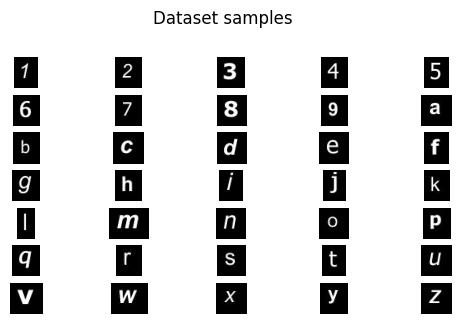

In [133]:
fig = plt.figure()
for i in range(35):
    path = f"content/val/{class_names[i]}/000001.png"
    img_test = Image.open(path)
    plt.subplot(10, 5, i+1)
    plt.axis('off')
    plt.imshow(img_test, cmap='gray_r')
    plt.suptitle("Dataset samples")

In [132]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
print(get_n_params(model))

20007
